<h1> Quora Question Pairs </h1>

<h2> 1. Business Problem </h2>

<h3> 1.1 Description </h3>
<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


<h3>1.2 Real World/Business Objectives and Constraints</h3>
1. The cost of a mis-classification can be very high. <br>
2. You would want a probability of a pair of questions to be duplicates so that you can <br> choose any threshold of choice.<br>
3. No strict latency concerns. <br>
4. Interpretability is partially important.

<h2>2.Machine Learning Problem</h2>
<h3>2.1 Data </h3>
<h4>2.1.1 Data Overviews</h4>
<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h4>2.1.2 Example Data Point </h4>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h3>2.2 Mapping the real world problem to an ML Problem</h3>
<h4>2.2.1 Type of Machine Learning Problem</h4>
<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h4> 2.2.2 Performance Metric </h4>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s):

- log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
- Binary Confusion Matrix

<h3>2.3 Train and Test Construction</h3>
<pr>We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.</pr>

<h2>3. Exploratory Data Analysis</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

<h3>3.1 Reading and Basic Stats</h3>

In [2]:
df = pd.read_csv('train.csv')
print('Number of data points: ',df.shape[0])

Number of data points:  404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.ther.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


##### Observations:
- We observe that we have a total of 404,290 pairs of questions.
- In the 'question1' column, we have 404,289 rows of data, meaning there is 1 missing value. 
- In the 'question2' column, we have 404,288 rows of data, meaning there are 2 missing values

<h4>3.1.1 Distribution of data points among output classes </h4>
<pr>Number of duplicate (similar) and non-duplicate (non-similar) questions.</pr>

<Axes: xlabel='is_duplicate'>

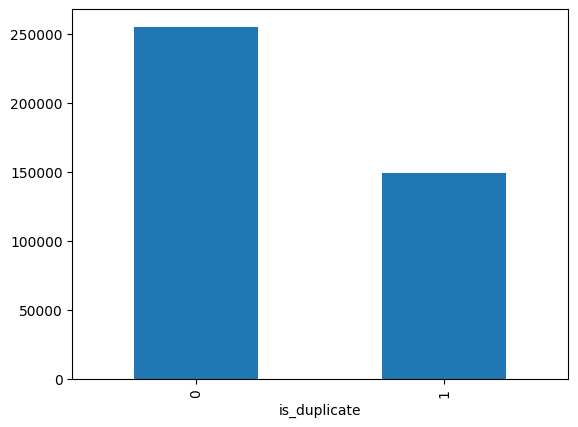

In [5]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [6]:
print("Question pairs are not similar( not duplicate) : {} %".format(100-round(df['is_duplicate'].mean()*100,2)))
print("Question pairs are similar (is duplicate=1) : {} %".format(round(df['is_duplicate'].mean()*100,2)))

Question pairs are not similar( not duplicate) : 63.08 %
Question pairs are similar (is duplicate=1) : 36.92 %


##### Observations:
- We have 63.08% of non duplicate question pairs.
- We have 36.92% of question pairs that are similar.

<h4>3.1.2 Number of Unique Questions</h4>

In [7]:
qids = pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_one_time = np.sum(qids.value_counts()>1)
print("Total number of unique questions are: {}".format(unique_qs))
print("Number of unique question that appear more than one time: {} ({}%)".format(qs_morethan_one_time,round(qs_morethan_one_time/unique_qs*100,2)))
print("Max number of times question repeated: {}".format(max(qids.value_counts())))

Total number of unique questions are: 537933
Number of unique question that appear more than one time: 111780 (20.78%)
Max number of times question repeated: 157


- Let's see it visualized graphically.

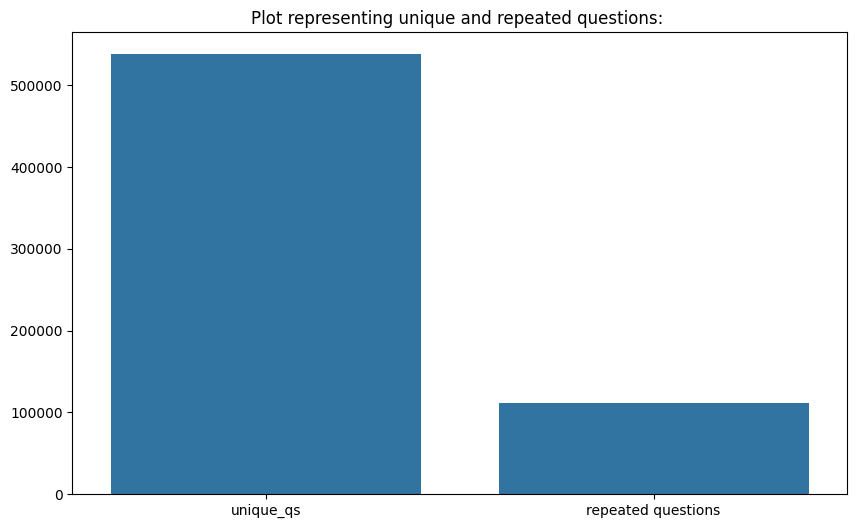

In [8]:
x = ['unique_qs','repeated questions']
y = [unique_qs,qs_morethan_one_time]
plt.figure(figsize=(10,6))
plt.title("Plot representing unique and repeated questions: ")
sns.barplot(x=x,y=y)
plt.show()

<h4>3.1.3 Checking For Duplicates</h4>

In [9]:
#checking for duplicate question pairs
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Number of duplicate questions",(pair_duplicates).shape[0]-df.shape[0])

Number of duplicate questions 0


<h4>3.1.5 Number of Occurrences of Each Question</h4>

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


Maximum number of times a single question is repeated: 157


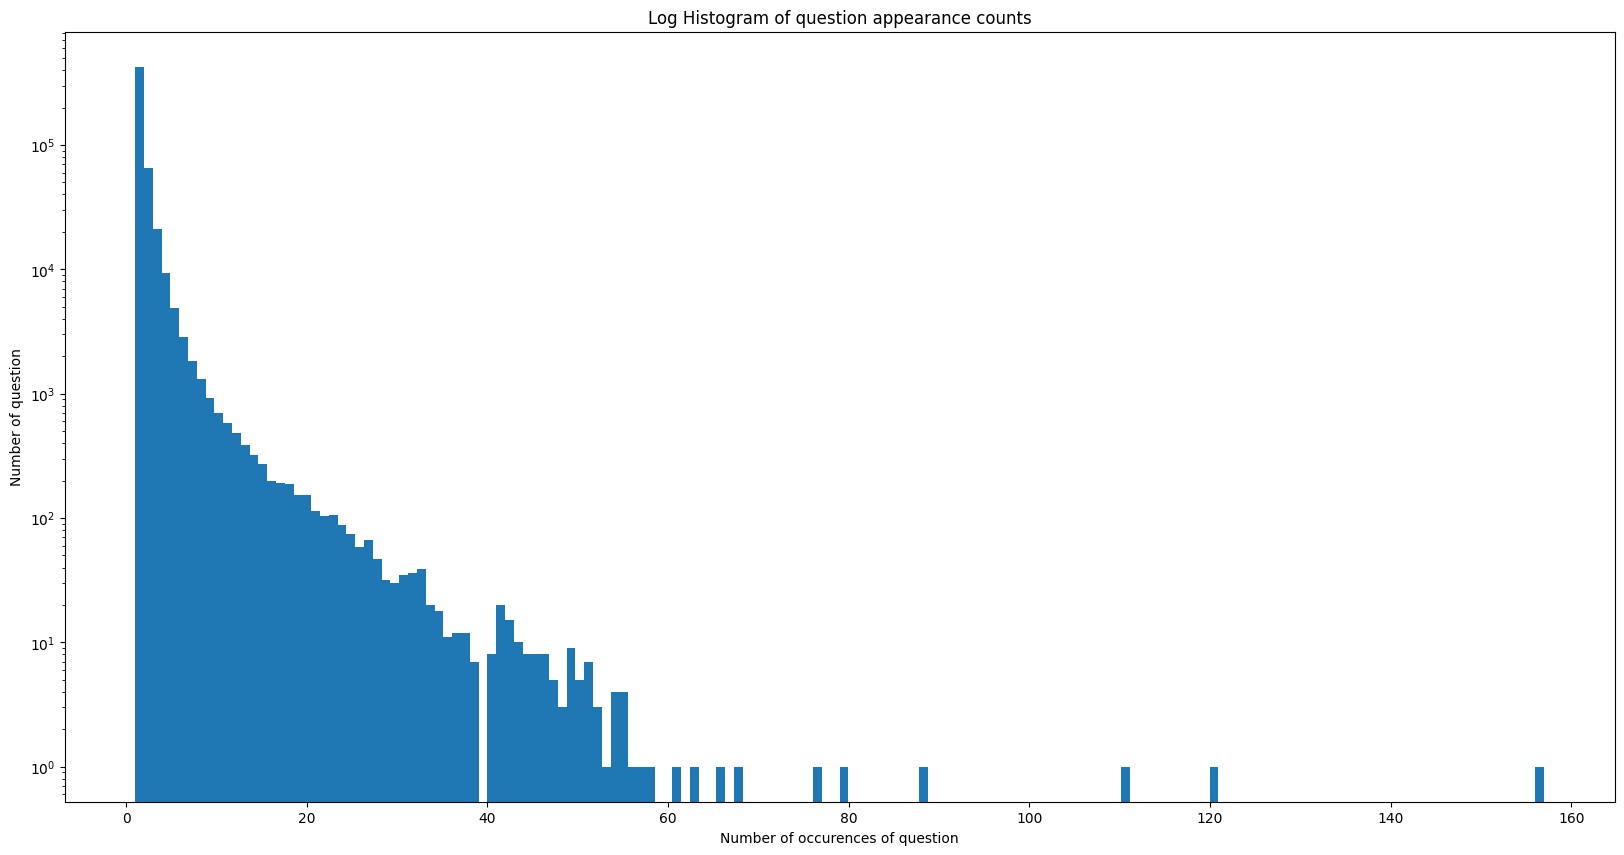

In [10]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=160)
import matplotlib as mpl 
mpl.rcParams['font.family']='DejaVu Sans'
plt.yscale('log',nonpositive='clip')
plt.title("Log Histogram of question appearance counts")
plt.xlabel("Number of occurences of question")
plt.ylabel("Number of question")
print("Maximum number of times a single question is repeated: {}".format(max(qids.value_counts())))

<h4>3.1.6 Checking for Null Values</h4>

In [11]:
nan_rows = df[df.isnull().any(axis=1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- In the 'question1' column, we have one missing row. 
- In the 'question2' column, we have two missing rows.

In [12]:
#filling the nan values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(axis=1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


### 3.2 Basic Feature Extraction (before cleaning) 
- <b>Let us now construct a few features like: </b>

- freq_qid1 = Frequency of qid1's
- freq_qid2 = Frequency of qid2's
- q1len = Length of q1
- q2len = Length of q2
- q1_n_words = Number of words in Question 1
- q2_n_words = Number of words in Question 2
- word_Common = (Number of common unique words in Question 1 and Question 2)
- word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
- word_share = (word_common)/(word_Total)
- freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
- freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [13]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
    df['q1len']=df['question1'].str.len()
    df['q2len']=df['question2'].str.len()
    df['q1_n_words']=df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words']=df['question2'].apply(lambda row: len(row.split(" ")))
    def normalized_word_common(row):
        w1 = set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)
    df['word_common']=df.apply(normalized_word_common,axis=1)
    def normalized_word_total(row):
        w1 = set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0 * (len(w1) + len(w2))
    df['word_total']=df.apply(normalized_word_total,axis=1)
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0 * len(w1&w2)/(len(w1)+len(w2))
    df['word_share']=df.apply(normalized_word_share,axis=1)
    df['freq_q1+q2']=df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2']=abs(df['freq_qid1']-df['freq_qid2'])
    df.to_csv('df_fe_without_preprocessing_train.csv',index=False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3>3.3Analysis of Some Extracted Features</h3>
<h4>3.3.1 Analysis of Question Length</h4>

- Here are some questions have only one single words.

In [14]:
print("Minimum length of the question in question1: ",min(df['q1_n_words']))
print('Minimum length of the question in question 2: ',min(df['q2_n_words']))
print("Number of question with minimum length in question 1: ",df[df['q1_n_words']==1].shape[0])
print("Number of question with minimum length in question 2 : ",df[df['q2_n_words']==1].shape[0])

Minimum length of the question in question1:  1
Minimum length of the question in question 2:  1
Number of question with minimum length in question 1:  67
Number of question with minimum length in question 2 :  24


<h4>3.3.2 Feature Analysis: word_share</h4>

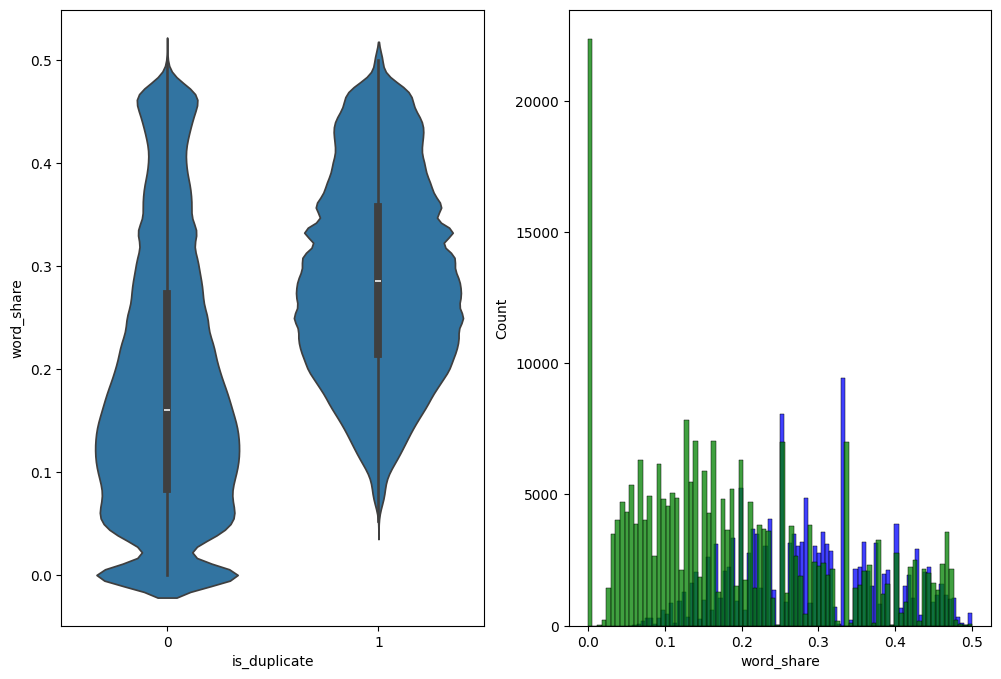

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df[0:])
plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate']==1.0]['word_share'],label='1',color='blue')
sns.histplot(df[df['is_duplicate']==0.0]['word_share'],label='0',color='green')
plt.show()

- <b> Observations: </b>
- The distributions for normalized word share exhibit some overlap on the far right-hand side, meaning there are quite a few questions with high word similarity.
- The average word share and the common number of words between qid1 and qid2 are higher when they are duplicates (i.e., similar).

<h4>3.3.3 Feature Analysis: word_common</h4>

<Axes: xlabel='word_common', ylabel='Count'>

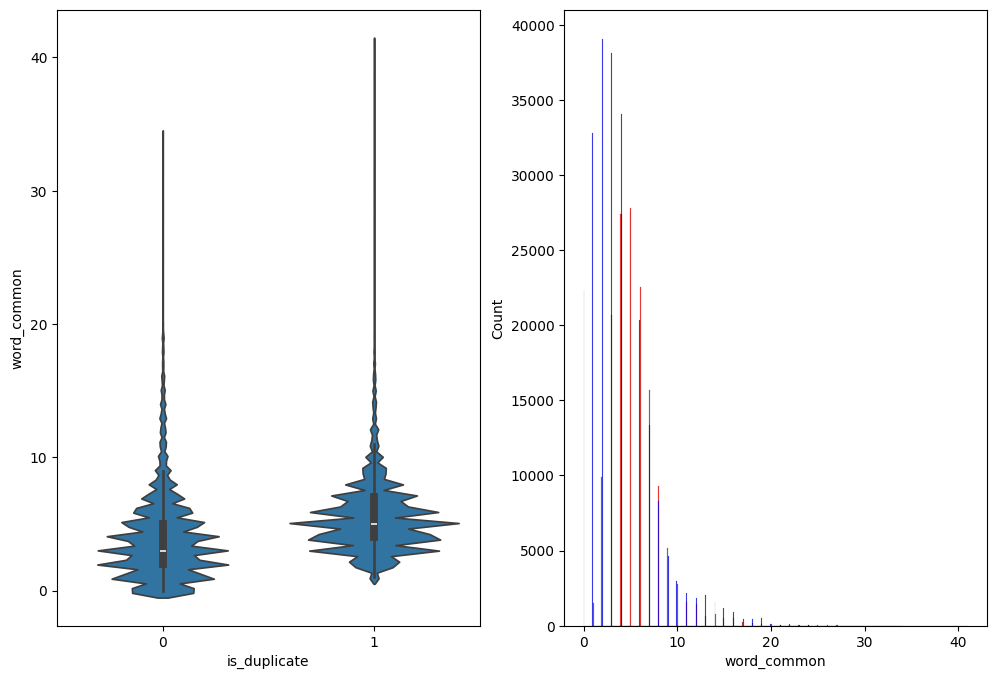

In [16]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_common',data=df[0:])
plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate']==1.0]['word_common'],label='1',color='red') 
sns.histplot(df[df['is_duplicate']==0.0]['word_common'],label='0',color='blue')

- Observation:
  1) The distributions of the word_common feature for similar and non-similar questions are highly overlapping.